# Template Notebook Evaluate offline models

Given a certain EXPERIMENT and RUN (selected by the user) saved in vertex experiments, show results of offline evaluation

In [1]:
# ---------------------------- read env variables used in the app ----------------------------
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")
REGION_GCP = os.environ.get("REGION_GCP", "")
BUCKET_GCP = os.environ.get("BUCKET_GCP", "")

## I) PACKAGES

In [2]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import gcsfs
import pickle

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import iqr

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# explanaible AI
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# #shap - shapash
# import shap
# from shapash import SmartExplainer

## II) LOAD ARTIFACTS MODEL

### 1. Load model name - SELECTED BY THE USER
The user needs to specify:
- EXPERIMENT (vertex experiment): the name of the dataset loaded
- RUN (vertex experiment): the name of the model to evaluate

In [3]:
# PARAMETERS BY THE USER
NAME_DATASET = 'develop-app-final-v2'
SELECTED_RUN = 'run-lr'

### 2. Load data train and test
In this case the datasets are loaded using the path that was defined when the artifacts are registry in vertex experiment. And not use the native methods of vertex to get the path of the artifacts

In [4]:
# example path
# f'gs://{bucket_gcs}/{experiment_name}/{run_name}/{path_artifact_locally}'

In [5]:
# X_train
path_X_train = f'gs://{BUCKET_GCP}/{NAME_DATASET}/{SELECTED_RUN}/X_train.pkl'
X_train = pd.read_pickle(path_X_train)

# y_train
path_y_train = f'gs://{BUCKET_GCP}/{NAME_DATASET}/{SELECTED_RUN}/y_train.pkl'
y_train = pd.read_pickle(path_y_train)

In [6]:
# X_test
path_X_test = f'gs://{BUCKET_GCP}/{NAME_DATASET}/{SELECTED_RUN}/X_test.pkl'
X_test = pd.read_pickle(path_X_test)

# y_test
path_y_test = f'gs://{BUCKET_GCP}/{NAME_DATASET}/{SELECTED_RUN}/y_test.pkl'
y_test = pd.read_pickle(path_y_test)

In [7]:
print('SHAPE DATA')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

print('\n')
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

SHAPE DATA
X_train:  (74, 9)
y_train:  (74, 1)


X_test:  (17, 9)
y_test:  (17, 1)


### 3. Load model trained

In [8]:
# load model
path_model = f'gs://{BUCKET_GCP}/{NAME_DATASET}/{SELECTED_RUN}/model.pkl'
model = pd.read_pickle(path_model)
model

LinearRegression()

In [9]:
# define a string with the name of the kind of machine learning model was trained
name_model_and_type = 'Random Forest Regressor'
name_model_and_type

'Random Forest Regressor'

### 4. Load list features

In [10]:
list_features = X_train.columns.tolist()

list_target = y_train.columns.tolist()

list_features_target = list_features + list_target

## III) OFFLINE EVALUATION MODEL
The offline evaluation of the model consist in evaluate how the model perform with its metrics and how the model will perform using to create a prescriptive machine learning systems. To achieve that not only the mean metrics with all data matters, also it is neccesary to see how to model perform into a delta change in the values, the model can generalize the data but not overtitting it, if there is some group of data that the model doesn't work, etc

The list of offline evaluation are:

1. Metrics

2. Plots predictions

3. Explanaible AI

4. Peturbation tests / Sensitivy Analysis

5. Metrics by segments

### 0. Get predictions

In [11]:
# predict
y_test_pred = model.predict(X_test)

# transform dataframe
y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred.columns = y_test.columns
y_test_pred.index = y_test.index

y_test_pred.head()

,VOO
Date,
2021-04-27,361.120295
2021-04-28,357.591945
2021-04-29,352.515508
2021-04-30,347.740513
2021-05-03,347.118990


### 1. Metrics
**Group 1 R2**
- R2

**Group 2 MSE**
- MSE

**Group 3 RMSE**
- RMSE
- RMSE MEAN RATIO (rmse mean ratio: rmse / mean_y_true)
- RMSE IQR RATIO (rmse iqr ratio: rmse / iqr_y_true)

**Group 4 MAE**
- MAE
- MAE MEAN RATIO
- MAE IQR RATIO

------
Calculating metrics for:
- Model trained
- Basic Model - mean target / predict common class
- Baseline Model
- Last best Model

#### 1.1 Metric for Model trained

In [12]:
def calculate_metrics_regressors_models(y, y_pred, model_name, decimals_round = None):
    """
    Calculate a certain number of metrics to evaluate regression models. The metrics are rounded to X decimals

    Args
        y (dataframe): y true
        y_pred (dataframe): y predicted with the model. In this codes are passed y_pred instead of X
        model_name (string): name of the model. This name is used when the metrics are saved to identify the model of these metrics
        decimals_round = Number of decimals to round the values. Defult None, no round the values.

    Return
        metrics_regressors (dataframe): dataframe with the metrics of the model in this datasets. Row: name metrics. Columns: value metrics
    """

    #### R2
    r2 = r2_score(y, y_pred)
    
    #### MSE
    mse = mean_squared_error(y, y_pred, squared = True)
    
    #### RMSE
    rmse = mean_squared_error(y, y_pred, squared = False)
    
    #### RMSE_MEAN_RATIO
    # rmse mean ratio: rmse / mean_y_true
    rmse_mean_ratio = rmse / y.mean().values[0]
    rmse_mean_ratio = round(100 * (rmse_mean_ratio), 2)
    
    #### RMSE_IQR_RATIO
    # rmse iqr ratio: rmse / iqr_y_true
    rmse_iqr_ratio = rmse / iqr(y)
    rmse_iqr_ratio = round(100 * (rmse_iqr_ratio), 2)
    
    #### MAE
    mae = mean_absolute_error(y, y_pred)
    
    #### MAE_RATIO
    mae_mean_ratio = mae / y.mean().values[0]
    mae_mean_ratio = round(100 * (mae_mean_ratio), 2)
    
    #### MAE_IQR_RATIO
    mae_iqr_ratio = mae / iqr(y)
    mae_iqr_ratio = round(100 * (mae_iqr_ratio), 2)
    
    
    
    #### JOIN INTO ONE DATAFRAME
    # create dataframe
    metrics_regressors = pd.DataFrame(index = [model_name])
    
    # add metrics
    metrics_regressors['r2'] = r2
    metrics_regressors['mse'] = mse
    metrics_regressors['rmse'] = rmse
    metrics_regressors['rmse_mean_ratio(%)'] = rmse_mean_ratio
    metrics_regressors['rmse_iqr_ratio(%)'] = rmse_iqr_ratio
    metrics_regressors['mae'] = mae
    metrics_regressors['mae_mean_ratio(%)'] = mae_mean_ratio
    metrics_regressors['mae_iqr_ratio(%)'] = mae_iqr_ratio
    
    # round
    metrics_regressors = metrics_regressors.astype('float')
    if decimals_round:
        metrics_regressors = metrics_regressors.round(decimals_round)


    return metrics_regressors

In [13]:
metrics = calculate_metrics_regressors_models(y = y_test, 
                                              y_pred = y_test_pred, 
                                              model_name = name_model_and_type, 
                                              decimals_round = None
                                             )
metrics

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
Random Forest Regressor,-46.144127,313.855513,17.715968,4.86,380.42,16.842967,4.62,361.68


#### 1.2 Basic Model - mean target / predict common class

In [14]:
# calculate mean y train. ADJUST BASIC MODEL
y_basic_model = y_train.mean().values[0]
y_basic_model

344.5390807830536

In [15]:
# generate vector to y_pred to evaluate. obs generate len according the y_true when the mean prediction will be compared
y_basic_model_pred = pd.DataFrame(y_basic_model * np.ones([y_test.shape[0]]))
y_basic_model_pred.index = y_test.index
y_basic_model_pred.columns = y_test.columns

In [16]:
# metrics basic model
metrics_basic_model = calculate_metrics_regressors_models(y = y_test, 
                                                          y_pred = y_basic_model_pred, 
                                                          model_name = 'd0eop_microkappa//Basic Model Pred', 
                                                          decimals_round = None
                                                         )
metrics_basic_model

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
d0eop_microkappa//Basic Model Pred,-61.928837,418.94004,20.468025,5.61,439.52,20.304745,5.57,436.02


### 2. Plot Predictions
- y_true vs y_pred
- hist_errors
- trend_errors
- features vs errors

#### 2.1 y_true vs y_pred

In [17]:
def plot_y_true_vs_y_pred(y, y_pred, title_plot):
    """
    Plot y_true vs y_pred (using matplotlib figure). y_true in X-axis, y_pred in Y-axis.

    Args:
        y (dataframe): dataframe with y-true values 
        y_pred (dataframe): dataframe with y-pred values
        title_plot (string): tittle in the plot
    
    Return
        fig (figure matplolib): figure to show, download, etc
    """
    fig, ax = plt.subplots()
    scatter_plot = ax.scatter(y, y_pred, alpha=0.3, marker='x', label='y_true vs y_pred')

    # Add bisectriz
    y_bisectriz = x_bisectriz = np.linspace(y.min()[0], y.max()[0], y.shape[0])
    ax.plot(x_bisectriz, y_bisectriz, label='Bisectriz', color='red', alpha=0.3)

    # Add names to axis
    ax.set_xlabel('Y true')
    ax.set_ylabel('Y pred')
    
    ax.set_title(title_plot)
    ax.legend()

    plt.close()
    return fig

In [18]:
y_true_y_pred = plot_y_true_vs_y_pred(y = y_test, 
                                      y_pred = y_test_pred, 
                                      title_plot = name_model_and_type
                                     )

#### 2.2 hist errors

In [19]:
def hist_errors_predictions(y, y_pred, title_plot, n_bins = 10):
    """
    Plot histogram of error in prediction: errors: abs(y_true vs y_pred) (using matplotlib figure)

    Args:
        y (dataframe): dataframe with y-true values 
        y_pred (dataframe): dataframe with y-pred values
        title_plot (string): tittle in the plot
        n_bins (integer): number of bins in the histogram. Default = 10
    
    Return
        fig (figure matplolib): figure to show, download, etc
    """
    # calculate error
    errors = y - y_pred
    errors = np.abs(errors) # error in abs value
    
    # hist error
    fig = plt.figure()
    plt.hist(errors, bins = n_bins)
    plt.xlabel('Error')
    plt.ylabel('Freq')
    plt.title(f'Histogram of Errors in Predictions:  abs(y - y_pred) - {title_plot}')

    plt.close()
    return fig

In [20]:
hist_errors = hist_errors_predictions(y = y_test, 
                                      y_pred = y_test_pred, 
                                        title_plot = name_model_and_type
                                   )

#### 2.3 Trend Errors
The split of the data was randomly instead of time split. TODO

#### 2.4 Features vs Errors
Plotear los errores para cada una de las observaciones de los datos. En el eje X se muestra los valores de una feature en concreto (pero no del resto de features que acompañan esta instancia). Son todos valores reales. La idea busca imitar a un PDP pero en lugar de utilizar los valores promedios del rsto de features se utilizan los valores reales

Intuición del gráfico
- La idea es poder terminar por ejemplo, si justo en los datos cuando las condiciones reales de operación se ven representadas por una feature X > 1000 siempre los errores son más altos

- Por ejemplo que la distribución del error en algunos segmentos sea notoriamente más alta. Se podría plantear separar el modelo hacer hacer foco en estas predicciones con los errores más altos

- Inspirado en tratar de replicar de cierta forma modelos por tramos y los modelos de boosting

In [21]:
def plot_errors_vs_one_feature(X, y, y_pred, title_plot, list_features, abs_error):
    """
    Plot errors vs features.

    Args:
        X (dataframe): dataframe with X true values - features
        y (dataframe): dataframe with y-true values 
        y_pred (dataframe): dataframe with y-pred values
        title_plot (string): tittle in the plot
        list_features (list): list of features that will plot againts the errrors. The features needs to be present in the data
        abs_error (boolean): True: Plot the absolute value of the errors abs(y_true - y_pred). False: Plot y_true - y_pred
    
    Return
        fig (figure matplolib): figure to show, download, etc
    """

    # calculate error
    errors = y - y_pred # error
    errors_abs = np.abs(errors) # errors in abs value
    if abs_error:
        errors_to_plot = errors_abs
    else:
        errors_to_plot = errors

    # for in features
    for feature in list_features:

        fig = plt.Figure()
        plt.scatter(X[feature],  # feature
                   errors_to_plot,  # errors y_true - y_pred
                    alpha = 0.5
                   )
        
        # Add names to axis
        plt.xlabel(f'Feature: {feature}')
        plt.ylabel('Errors y')

        plt.title(title_plot)
        #plt.legend()
        plt.show()

    ############################## 
    #plt.close()
    #return fig # this code needs to be modified into a subplot format to return it

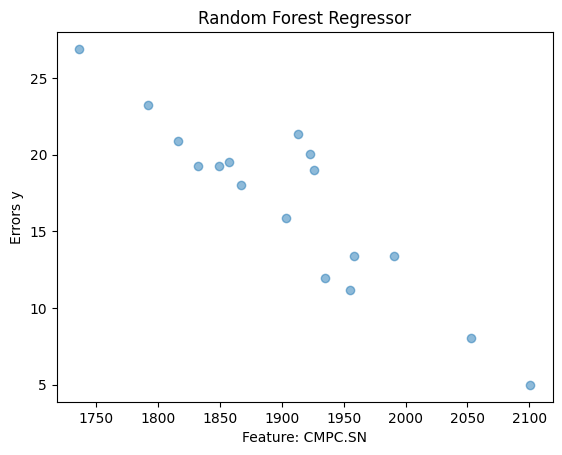

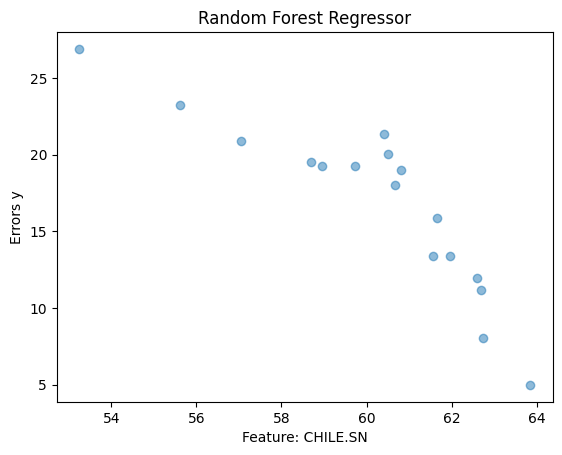

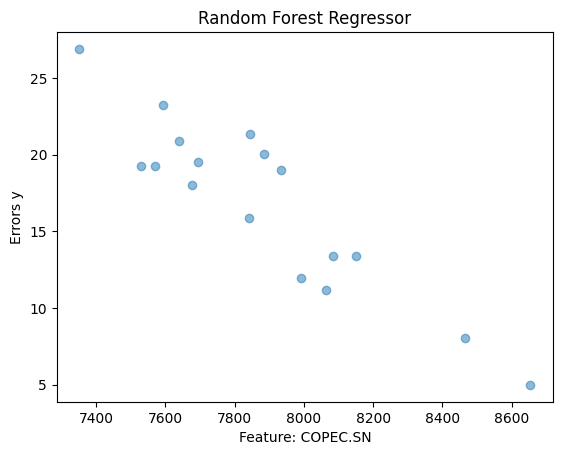

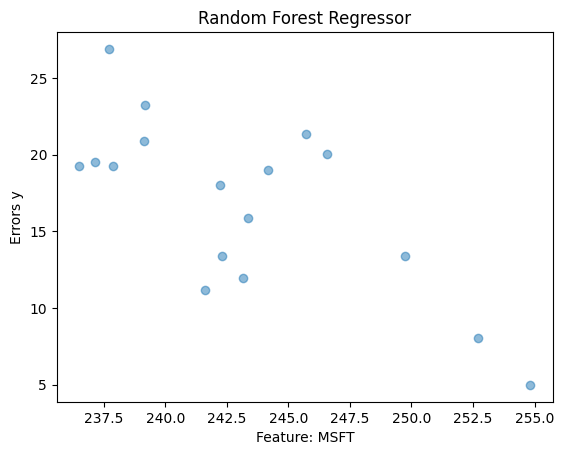

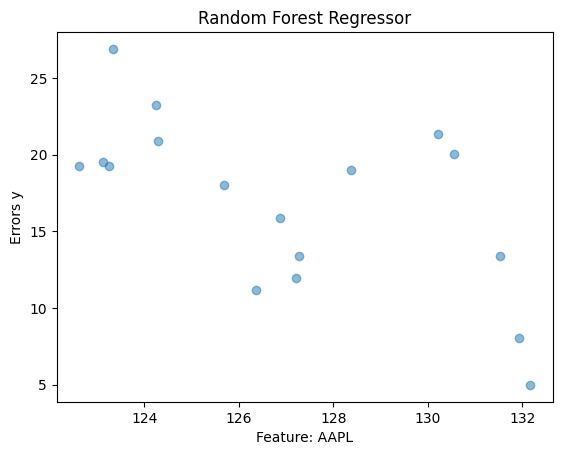

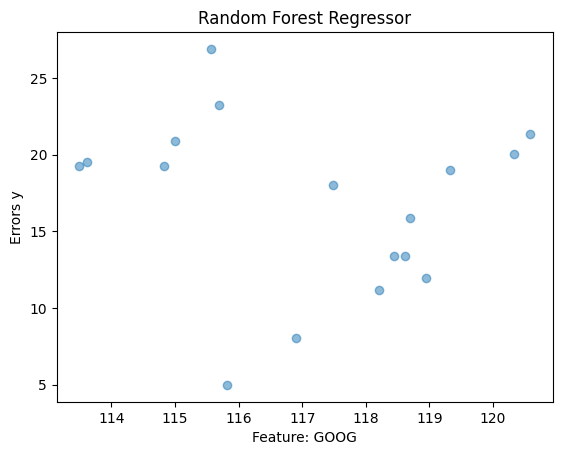

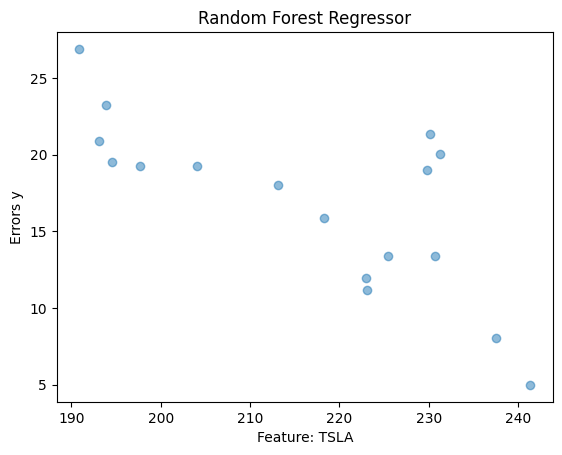

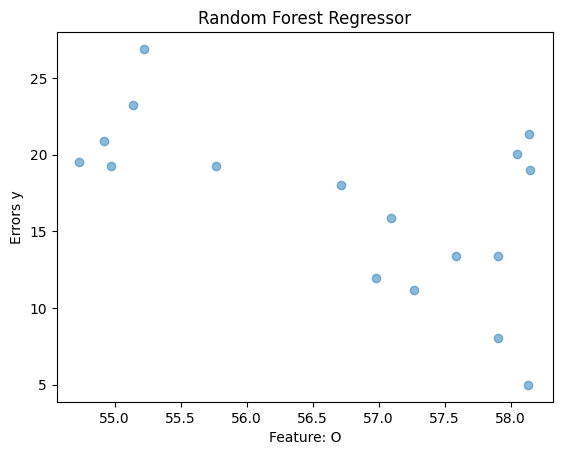

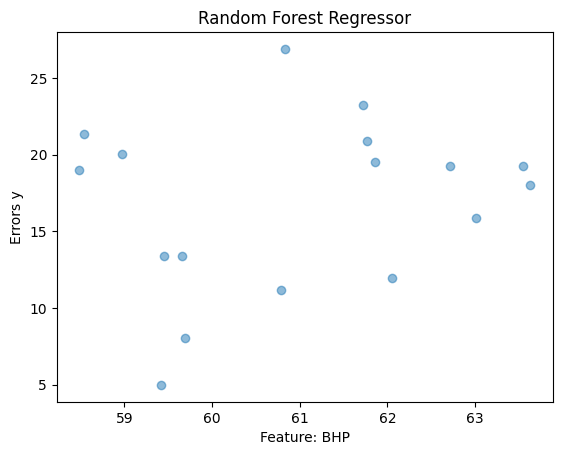

In [22]:
erorrs_vs_features = plot_errors_vs_one_feature(X = X_test,
                                                y = y_test, 
                                                y_pred = y_test_pred, 
                                                title_plot = name_model_and_type,
                                                list_features = X_test.columns.tolist(), 
                                                abs_error = True
                                               )

### 3. Explanaible AI
Hay muchas herramientas de explanaible AI. Aquí se muestran las más clásicas (y utilizando las implementaciones de sklearn cuando es posible). Herramientas:
- Permutation Importances
- Permutation Importances with Noise Features
- Partial Depende Plots (PDP)
- Shapley values

#### 3.1 Permutation Importances
- Obtener la importancia de las variables luego de realizar permutaciones en cada feature de forma individual y observar cómo varía el poder predictivo del modelo
- The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set.

In [23]:
def permutation_importances(model, list_features, X, y):
    """
    Calculate permutation importances
    """
    # calculate permutation importances
    results = permutation_importance(estimator = model, 
                                     X = X, 
                                     y = y, 
                                     n_repeats = 30,
                                     random_state = 42
                                    )

    # define a series with importances (mean) of each feature
    df_importances = pd.Series(results.importances_mean, index = list_features)

    # plot
    fig, ax = plt.subplots()
    df_importances.plot.bar(yerr = results.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation")
    ax.set_ylabel("Mean R2 decrease")
    fig.tight_layout()

    plt.close()
    return fig, df_importances

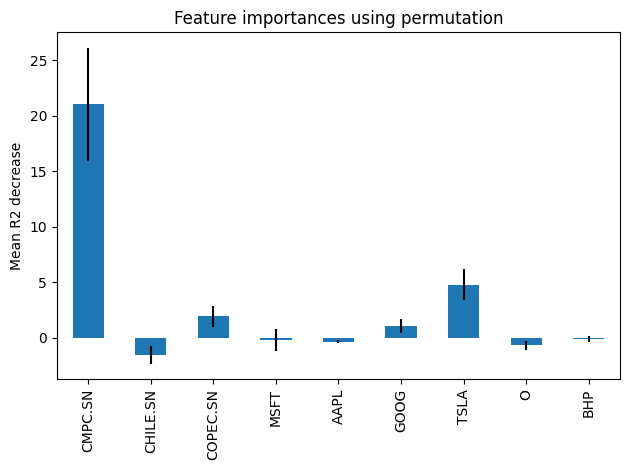

In [24]:
plot_permutation_importances, df_importances = permutation_importances(model, list_features, X_test, y_test)
plot_permutation_importances

#### 3.2 Permutation Importances with Noise Features
- Entrenar modelos de ML con 1-2 features que son solo ruido - Distribución Normal con Media 0 y Varianza 1
- Poder evaluar si el modelo utilizado es tan potente que es capaz de ajustarse al ruido y determinar estas variables como más importantes

In [25]:
def permutation_importances_noise(model, X_train, y_train, X_test, y_test):
    """
    Calculate permutation importances adding noise in the dataset
    """
    
    # create instance model and data noise since original instance model trained
    import copy
    model_noise = copy.deepcopy(model)
    
    X_train_noise = X_train.copy()
    y_train_noise = y_train.copy()
    X_test_noise = X_test.copy()
    y_test_noise = y_test.copy()

    # create dataframe train - test with noise
    np.random.seed(42)
    X_train_noise['noise_1'] = np.random.normal(size = X_train.shape[0])
    X_train_noise['noise_2'] = 10 * np.random.normal(size = X_train.shape[0])
    
    X_test_noise['noise_1'] = np.random.normal(size = X_test.shape[0])
    X_test_noise['noise_2'] = 10 * np.random.normal(size = X_test.shape[0])

    # train model
    model_noise.fit(X_train_noise, y_train_noise)
    
    # get predictions
    y_test_noise_pred = model_noise.predict(X_test_noise)
    
    #### PDP - utilizar funcion anterior - re utilizar funcion
    # calculate permutation importances
    results = permutation_importance(estimator = model_noise, 
                                     X = X_test_noise, 
                                     y = y_test_noise, 
                                     n_repeats = 30,
                                     random_state = 42
                                    )
    
    # define a series with importances (mean) of each feature
    df_importances = pd.Series(results.importances_mean, index = X_test_noise.columns.tolist() )
    
    # plot
    fig, ax = plt.subplots()
    df_importances.plot.bar(yerr = results.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation")
    ax.set_ylabel("Mean R2 decrease")
    fig.tight_layout()
    
    plt.close()

    return fig

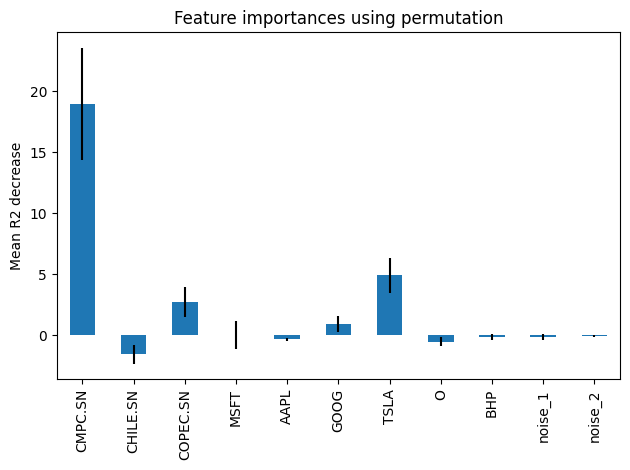

In [26]:
plot_permutation_importances_noise = permutation_importances_noise(model, X_train, y_train, X_test, y_test)
plot_permutation_importances_noise

#### 3.3 Partial Dependence Plot
Gráficos de dependencia parcial. Mostrar cómo cambian los valores de la predicción dado el cambio de los valores de una feature mientras se mantiene el resto en sus valores medios

In [27]:
def pdp_plot_old(model, X):
    """
    Partial depedence plot
    """
    
    # plot
    display = PartialDependenceDisplay.from_estimator(
        estimator = model,
        X = X,
        random_state = 42,
        features = X.columns.tolist(),
        n_cols = 3
    )
    
    # Crear una figura con el tamaño deseado
    fig = plt.figure(figsize=(15, 10))
    
    # Mostrar el gráfico
    display.plot(ax=plt.gca())  # Utiliza el eje actual de la figura actual
    plt.tight_layout()

    plt.close()
    return fig

In [28]:
def pdp_plot(model, X):
    """
    Partial depedence plot
    """
    
    # plot
    display = PartialDependenceDisplay.from_estimator(
        estimator = model,
        X = X,
        random_state = 42,
        features = X.columns.tolist(),
        n_cols = 3
    )

    # get plot
    fig_pdp_plot = plt.gcf() # get actual plt figure
    fig_pdp_plot.set_size_inches(15, 10) # change size plot
    plt.close() # close plt

    return fig_pdp_plot

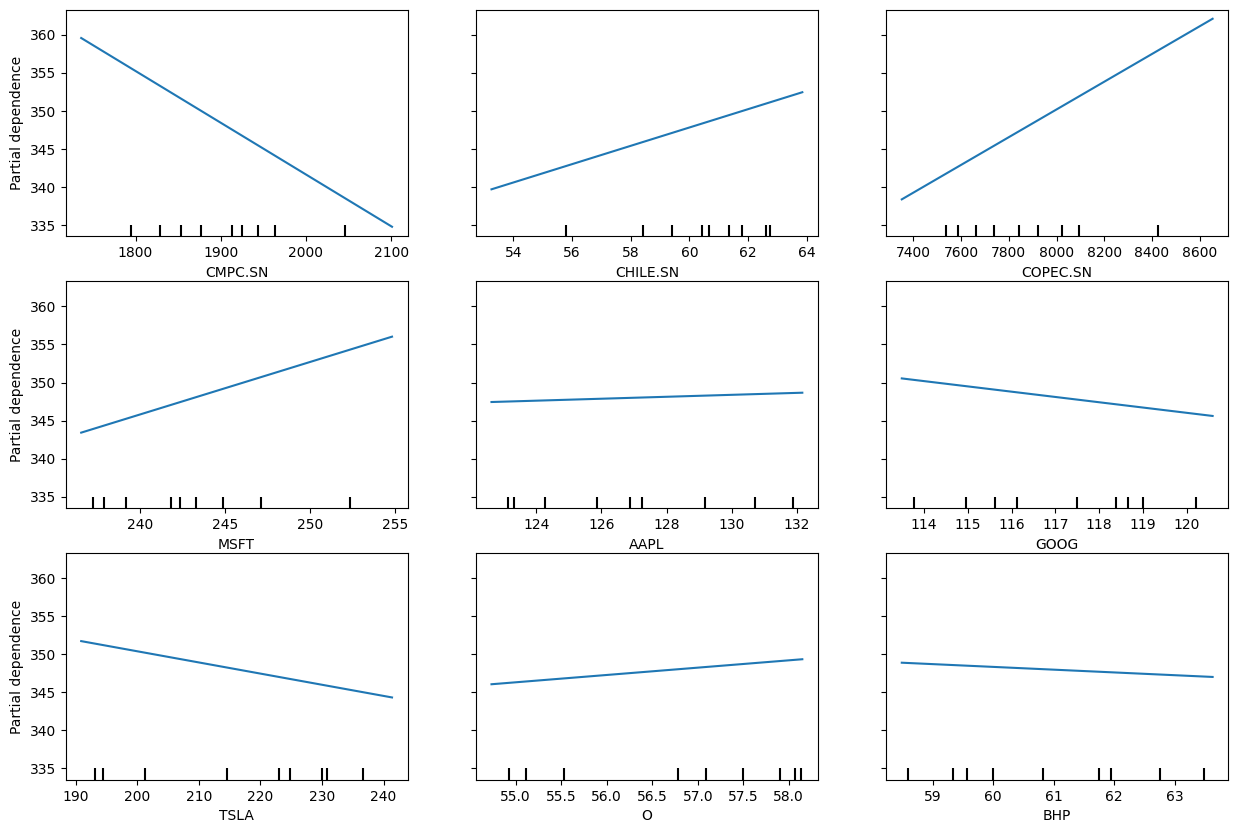

In [29]:
fig_pdp = pdp_plot(model, X_test)
fig_pdp

#### 3.4 Shapley Values
Plots utilizando el package SHAP

In [30]:
# TO DO - shap values
# TO DO - shapash package

### 4. Perturbation test - Sensitivy Analysis
The idea of this is to analyze the effect on the predictions by adding small perturbations to the data (small perturbation on a feature).

For example, having the model y = f(x1, x2, x3). The goal is to answer the questions, what if I make a small modification to the feature x1, how will the model prediction change with this small perturbation (a priori this small perturbation does not affect the prediction)?

In these projects, where the goal is to use machine learning models to generate recommendations (prescriptive analysis), it is necessary that the model can generalize sufficiently because the optimizer will change the values of the features looking for the optimal value to maximize this objective function.

**OBS: these are my codes and my ideas (searching a package that do that). The user set an epsilon variation in a specific feature. Then the codes generate two dataframe with "feature +- epsilon" and get the preditions with this variations. Finally generate a plot with ""preditions, predictions_plus_epsilon, preditions_minus_epsilon""**

#### 4.1 Peturbation test one feature global plots

In [31]:
def perturbation_test_one_feature_global_analysis(tag_sensitivy_analysis, epsilon, model, X, y, y_pred):
    """
    (Perturbation +- epsilon) in one feature and predict with this perturbations. Plot a histogram of predited values with
    "true values", "pred values", "pred values - epsilon" and "pred values + epsilon"

    Args
        tag_sensitivy_analysis (string): tag sensitivy analysis
        epsilon (float/integer): epsilon perturbation in the data
        X (dataframe): features dataframe
        y (dataframe): target dataframe (true values)
        y_pred (dataframe): target predicted dataframe (prediction without perturbation)

    Return
        plot
    """
    
    ###### get list of original features
    list_original_features = X.columns.tolist()
    
    ###### clone data
    X_sensitivy = X.copy()
    y_pred_sensitivy = y_pred.copy()
    y_pred_sensitivy.columns = ['target']
    
    ###### calculate the percentual variation of the epsilon in the feature (mean value). how is the percentual variation of the data
    epsilon_percent_impact = round(100 * epsilon / X_sensitivy[tag_sensitivy_analysis].mean(), 2)
    print(f'-- Epsilon percent impact: {epsilon_percent_impact}%')
    
    ###### generate two columns of the feature: (feature-epsilon, feature+epsilon)
    X_sensitivy[tag_sensitivy_analysis + '_-_epsilon'] = X_sensitivy[tag_sensitivy_analysis] - epsilon
    X_sensitivy[tag_sensitivy_analysis + '_+_epsilon'] = X_sensitivy[tag_sensitivy_analysis] + epsilon
    
    
    ###### get the predicted values with the perturbation (feature-epsilon, feature+epsilon)
    # clone list original features to reeplace the feature with epsilon values
    list_features_minus_epsilon = list_original_features.copy()
    list_features_plus_epsilon = list_original_features.copy()
    
    # get the position of the feature with sensitivy analysis
    idx_tag_sensitivy_analysis = list_features_minus_epsilon.index(tag_sensitivy_analysis)
    
    # redefine list of features with the names of features with epsilon values
    list_features_minus_epsilon[idx_tag_sensitivy_analysis] = tag_sensitivy_analysis + '_-_epsilon'
    list_features_plus_epsilon[idx_tag_sensitivy_analysis] = tag_sensitivy_analysis + '_+_epsilon'
    
    ###### model.predict with its epsilon values
    # generate data minus and plus
    data_sensitivy_minus = X_sensitivy[list_features_minus_epsilon] # filter
    data_sensitivy_minus.columns = list_original_features # rename columns
    data_sensitivy_plus = X_sensitivy[list_features_plus_epsilon]
    data_sensitivy_plus.columns = list_original_features
    
    # save predict values
    y_pred_sensitivy['target_'+ '_-_epsilon'] = model.predict(data_sensitivy_minus) # predecir con delta minus de variable de 
    y_pred_sensitivy['target_'+ '_+_epsilon'] = model.predict(data_sensitivy_plus)
    
    
    sns.kdeplot(y, label = 'true')
    sns.kdeplot(y_pred_sensitivy['target'], label = 'pred')
    sns.kdeplot(y_pred_sensitivy['target_'+ '_-_epsilon'], label = 'pred-epsilon(feature)')
    sns.kdeplot(y_pred_sensitivy['target_'+ '_+_epsilon'], label = 'pred+epsilon(feature)')
    plt.legend()

    # get a python variable with plt figure
    fig_plot_sensibility = plt.gcf() # get actual plt figure
    plt.close() # close plt

    return fig_plot_sensibility

In [32]:
# get the most important feature
MOST_IMPORTANT_FEATURE = df_importances.sort_values(ascending = False).index.values[0]

In [33]:
fig_sensitivy_one_feature = perturbation_test_one_feature_global_analysis(tag_sensitivy_analysis = MOST_IMPORTANT_FEATURE, # most important feature for example
                                                                          epsilon = 1, 
                                                                          model = model,
                                                                          X = X_test.copy(), 
                                                                          y = y_test.copy(), 
                                                                          y_pred = y_test_pred.copy()
                                                                          )

-- Epsilon percent impact: 0.05%


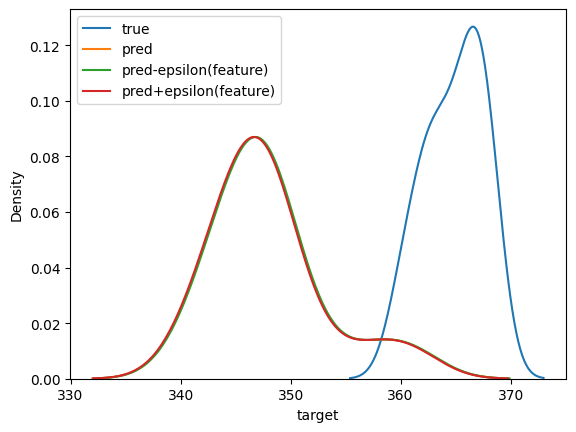

In [34]:
fig_sensitivy_one_feature

#### 4.2 Peturbation test one feature individual analysis
The idea here is analysis the efect of changing the values of one feature manually for one instance

In [35]:
# base instance - real data
instance_base = X_test.head(1)
instance_base

,CMPC.SN,CHILE.SN,COPEC.SN,MSFT,AAPL,GOOG,TSLA,O,BHP
Date,,,,,,,,,
2021-04-27,2100.969645,63.851897,8654.155924,254.831421,132.171717,115.819333,241.371109,58.130501,59.41126


In [36]:
# prediction base instance
model.predict(instance_base)

array([[361.12029513]])

In [37]:
# generate a perturbation in one feature. For example modifying chemicals
instance_perturbation = instance_base.copy()
instance_perturbation[MOST_IMPORTANT_FEATURE] = 6.1 # PERTURBATION
instance_perturbation

,CMPC.SN,CHILE.SN,COPEC.SN,MSFT,AAPL,GOOG,TSLA,O,BHP
Date,,,,,,,,,
2021-04-27,6.1,63.851897,8654.155924,254.831421,132.171717,115.819333,241.371109,58.130501,59.41126


In [38]:
# predict perburbation instance
model.predict(instance_perturbation)

array([[503.57263032]])

### 5. Metrics by segments

#### 5.0 Analysis

#### 5.1 Segment by most important feature

In [39]:
def metrics_segmentation_analysis(tag_segment, X, y, y_pred, metrics):
    """
    """
    
    # get percentile and bins
    percentile_index, bins = pd.qcut(X[tag_segment], 5, labels=False, retbins=True)

    # add columns percentile in y test
    y_percentile = y.copy()
    y_percentile['percentile_index'] = percentile_index
    
    # add columns percentile in y test pred
    y_pred_percentile = y_pred.copy()
    y_pred_percentile['percentile_index'] = percentile_index


    # show metrics
    metrics_percentile = pd.DataFrame()
    for index in range(5):
        
        # calculate values start and end
        start_segment = round(bins[index], 3)
        end_segment = round(bins[index+1], 3)
    
        # filter test data ground truth
        y_percentile_aux = y_percentile[y_percentile['percentile_index'] == index]
        y_percentile_aux = y_percentile_aux.drop(columns = 'percentile_index')
          
        # filter test data pred
        y_pred_percentile_aux = y_pred_percentile[y_pred_percentile['percentile_index'] == index]
        y_pred_percentile_aux = y_pred_percentile_aux.drop(columns = 'percentile_index')
            
        # calculate metrics
        metrics_percentile_aux = calculate_metrics_regressors_models(y = y_percentile_aux,
                                            y_pred = y_pred_percentile_aux, 
                                            model_name = f'Percentile {index}', 
                                            decimals_round = None
                                           )
    
        # append
        metrics_percentile = pd.concat([metrics_percentile, metrics_percentile_aux])


    # append original score
    output_metrics = pd.concat([metrics, metrics_percentile])


    return output_metrics

In [40]:
tag_segment = MOST_IMPORTANT_FEATURE

In [41]:
metrics_segmentation = metrics_segmentation_analysis(tag_segment, X_test, y_test, y_test_pred, metrics)
metrics_segmentation

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
Random Forest Regressor,-46.144127,313.855513,17.715968,4.86,380.42,16.842967,4.62,361.68
Percentile 0,-105.051819,517.682712,22.752642,6.22,1050.01,22.571522,6.17,1041.65
Percentile 1,-465.609301,359.317922,18.955683,5.21,1884.51,18.944801,5.21,1883.43
Percentile 2,-77.391336,370.105977,19.238139,5.25,784.90,19.096377,5.21,779.12
Percentile 3,-19.314239,209.505304,14.474298,3.99,406.54,14.038901,3.87,394.31
Percentile 4,-42.117013,112.006314,10.583304,2.90,897.99,9.951030,2.73,844.34
